#**BYO Post Interview Task**
You will research LLM fine tuning


step 1. Exploretroy Data Analysis<br>
you will be fine tunining the LLM defined at (2) using with the data linked below<br>https://drive.google.com/file/d/18g5y5GmBQNgU8z2fPdushrdu0XfmQjph/view?usp=drive_link<br>
explain your findings.<br>
the LLM should be fine-tuned to generate both speakers

step 2. Define an LLM - you can define it using your custom resouces from git

Step 3. Using steps (1) and (2) fine-tune the pretraind LLM<br>
Feel free to use any method of your choice.

Step 4. Use step (1) for EDA on the following data<br>
https://drive.google.com/file/d/1Rm-ItCDv44iDqLaaEZTz-Cqu_xQPM6s5/view?usp=drive_link<br>
explain your finidng.<br>
Fine-tune the weights resulted at step (3), keep in mind the Stability-Plasticity trade-off, try to minimize forgetfullness, explain the algorithm you chose to use.<br>


Step 5. Compose a test that shows forgetness of the data learnd at step (3) at the second fine-tune at stage (4).<br>
Explain your findings, suggest other research methods within the continual learning domain that may be worth trying.

## GOOD LUCK!
for questions feel free to email me<br>
sefi@byo-x.ai

# Step 0: Install required libraries

In [2]:
!pip install --upgrade "transformers==4.52.3" "datasets==3.6.0" "peft==0.15.2" datasets peft bitsandbytes accelerate gdown matplotlib seaborn ipywidgets

# Step 1: Imports & device

In [3]:
import os, math, random, warnings, itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          TrainingArguments, Trainer,
                          DataCollatorForLanguageModeling)
from peft import LoraConfig, get_peft_model

warnings.filterwarnings("ignore")
device = torch.device("cpu")
print("Torch:", torch.__version__, "| device:", device)

Torch: 2.7.0+cpu | device: cpu


# Step 2: Load csv from local

In [4]:

DATA1 = "lee_cronin3.csv"  
DATA2 = "lisa_randall.csv"

assert os.path.exists(DATA1) and os.path.exists(DATA2), "CSV files not found!"
print("Found:", DATA1, "|", DATA2)


Found: lee_cronin3.csv | lisa_randall.csv


# Step 3: EDA

 lee_cronin3.csv | rows: 791


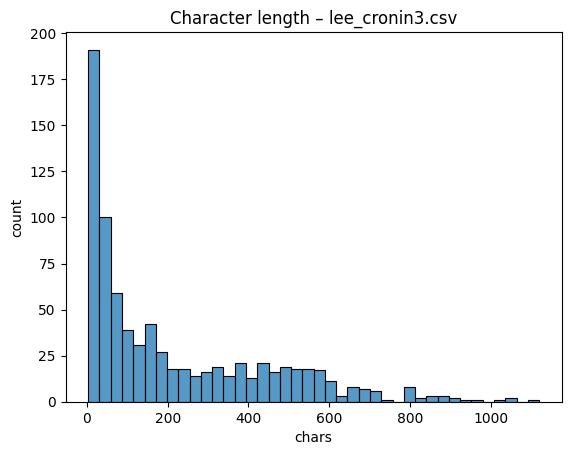


 Speaker balance:
speaker
lee cronin     447
lex fridman    344
Name: count, dtype: int64

 Char-length stats:


count     791.000000
mean      216.835651
std       230.483775
min         3.000000
25%        32.000000
50%       124.000000
75%       376.000000
max      1120.000000
Name: n_chars, dtype: float64


 Shortest line:
  so

 Longest line:
  thats what a lot of people say so the way to really get to genuine novelty and assembly theory shows you the way is to have different causal chains overlap and this really really resonates with the time is fundamental argument and if you are bringing together a couple of objects with different init ...

 Null counts:
 Unnamed: 0    0
speaker       0
text          0
n_chars       0
dtype: int64

 Rough unique-word count: 3,035
 lisa_randall.csv | rows: 219


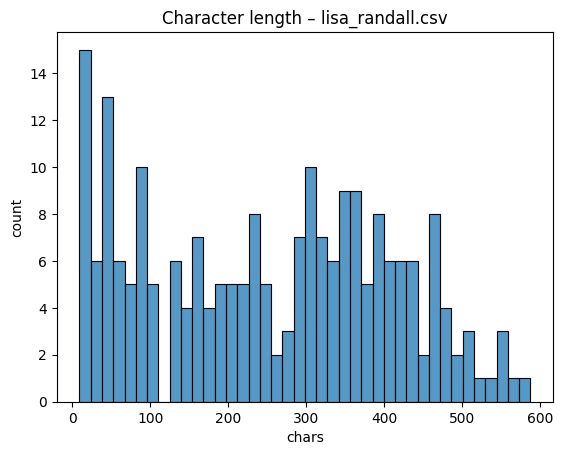


 Speaker balance:
speaker
lisa randall    137
lex fridman      82
Name: count, dtype: int64

 Char-length stats:


count    219.000000
mean     251.196347
std      156.876603
min        9.000000
25%       95.500000
50%      260.000000
75%      372.500000
max      588.000000
Name: n_chars, dtype: float64


 Shortest line:
  politics

 Longest line:
  i think theyre not as scared as they should be about nuclear weapons to be honest i think thats more serious danger than people realize i think people are a little bit more scared about pandemics than they were before but i still say theyre not super scared about it so youre right there are these m ...

 Null counts:
 Unnamed: 0    0
speaker       0
text          0
n_chars       0
dtype: int64

 Rough unique-word count: 1,409


In [5]:
def run_eda(csv_path, speaker_tokens, tokenizer=None, max_len_plot=120):
    df = pd.read_csv(csv_path)
    print(f" {csv_path} | rows: {len(df)}")

    # clean speaker names
    df["speaker"] = df["speaker"].str.strip().str.lower()

    # length features
    df["n_chars"] = df["text"].str.len()
    if tokenizer is not None:
        df["n_tokens"] = df["text"].apply(lambda t: len(tokenizer(t).input_ids))

    # char-length histogram
    sns.histplot(df["n_chars"], bins=40)
    plt.title(f"Character length – {os.path.basename(csv_path)}")
    plt.xlabel("chars"); plt.ylabel("count")
    plt.show()

    # token-length histogram
    if "n_tokens" in df:
        sns.histplot(df[df["n_tokens"] <= max_len_plot]["n_tokens"], bins=max_len_plot)
        plt.title(f"Token length ≤{max_len_plot} – {os.path.basename(csv_path)}")
        plt.xlabel("tokens"); plt.ylabel("count")
        plt.show()

    # speaker balance
    print("\n Speaker balance:")
    print(df["speaker"].value_counts())

    # descriptive stats
    print("\n Char-length stats:"); display(df["n_chars"].describe())
    if "n_tokens" in df:
        print("\n Token-length stats:"); display(df["n_tokens"].describe())

    # shortest / longest
    print("\n Shortest line:\n", df.loc[df.n_chars.idxmin(), "text"][:200])
    longest = df.loc[df.n_chars.idxmax(), "text"]
    print("\n Longest line:\n", longest[:300], "..." if len(longest) > 300 else "")

    # null check
    print("\n Null counts:\n", df.isna().sum())

    # rough vocab size
    vocab = set(itertools.chain.from_iterable(df["text"].str.split()))
    print(f"\n Rough unique-word count: {len(vocab):,}")

    # map speaker tokens
    df["speaker_token"] = df["speaker"].map(speaker_tokens)
    return df

SPEAKER_TOKENS = {
    "lex fridman": "<lex>",
    "lee cronin":   "<lee>",
    "lisa randall": "<lisa>",
}

# first pass without token stats (tokenizer not loaded yet)
df1 = run_eda(DATA1, SPEAKER_TOKENS)
df2 = run_eda(DATA2, SPEAKER_TOKENS)


# Step 4: tokenizer & small base model

In [6]:
### Cell 4′ – tokenizer & base model (with true PAD token)

MODEL_NAME = "distilgpt2"
MAX_LEN    = 100

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 1) add a real PAD token instead of reusing EOS
tokenizer.add_special_tokens({
    "pad_token": "[PAD]",
    "additional_special_tokens": list(SPEAKER_TOKENS.values())
})

# 2) load & resize model embeddings
base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
base_model.resize_token_embeddings(len(tokenizer))

# 3) tell the model what to use for padding
base_model.config.pad_token_id = tokenizer.pad_token_id


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


# Step 5: Dataset builders

In [7]:

def tokenize_batch(batch):
    text = batch["speaker_token"] + " " + batch["text"]
    tok  = tokenizer(
        text,
        truncation=True,
        max_length=MAX_LEN,
        padding="max_length",   # now safe because we set tokenizer.pad_token
    )
    tok["labels"] = tok["input_ids"].copy()
    return tok

def build_ds(df):
    ds = Dataset.from_pandas(df[["speaker_token", "text"]])
    return ds.map(tokenize_batch, remove_columns=["speaker_token", "text"])

# Dataset-1 splits
ds1_full = build_ds(df1)
ds1      = ds1_full.train_test_split(test_size=0.1, seed=42)

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)


Map:   0%|          | 0/791 [00:00<?, ? examples/s]

# Step 6: Phase-1 LoRA fine-tune (Lee Cronin & Lex)

In [16]:
from transformers import SchedulerType

lora_targets = ["c_attn", "c_proj"]   # GPT-2 attention & output projections

peft_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=lora_targets,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(base_model, peft_cfg)
print("Trainable params:", model.num_parameters(only_trainable=True))

args_p1 = TrainingArguments(
  output_dir="checkpoints/phase1",
  per_device_train_batch_size=2,
  gradient_accumulation_steps=16,
  num_train_epochs=2,                
  learning_rate=2e-4,
  lr_scheduler_type=SchedulerType.LINEAR,  
  warmup_ratio=0.1,                 
  logging_steps=25,
  save_total_limit=2,
  save_safetensors=False,             
  report_to=[]
)


trainer_p1 = Trainer(
    model=model,
    args=args_p1,
    train_dataset=ds1["train"],
    # remove eval_dataset from constructor
    data_collator=data_collator,
)

# 1) train
trainer_p1.train()

# 2) manual evaluation
metrics = trainer_p1.evaluate(eval_dataset=ds1["test"])
print("Evaluation on Dataset-1 test:", metrics)

# 3) save the model
trainer_p1.save_model("checkpoints/phase1")
tokenizer.save_pretrained("checkpoints/phase1")
print(" Phase-1 checkpoint saved.")


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainable params: 811008


Step,Training Loss
25,4.878900


Evaluation on Dataset-1 test: {'eval_loss': 4.548065185546875, 'eval_runtime': 8.9955, 'eval_samples_per_second': 8.893, 'eval_steps_per_second': 1.112, 'epoch': 2.0}
 Phase-1 checkpoint saved.


# Step 7: sample generations after Phase-1

In [17]:
def generate(
    prompt: str,
    max_new: int = 60,
    temperature: float = 0.6,
    top_p: float = 0.9,
    repetition_penalty: float = 1.1,
    no_repeat_ngram_size: int = 3,
):
    model.eval()
    # Tokenize + get attention mask
    enc = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LEN,
        padding="max_length",
    )
    input_ids      = enc.input_ids
    attention_mask = enc.attention_mask

    # Generate with proper pad/eos and sampling params
    out = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        no_repeat_ngram_size=no_repeat_ngram_size,
    )
    text = tokenizer.decode(out[0], skip_special_tokens=False)
    print(text.replace("[PAD]", ""))  # strip any visible PAD tokens

# Try both speakers
generate("<lex>")
generate("<lee>")


<lex>, you need to make sure that the system is working correctly and it's not going to work in a way where your users are getting very excited about what they're doing or just trying to get their own algorithms out there.
So I'm talking about some of these things with my colleagues who say
<lee> The next time you’re going to go into the world of physics, and in order to create a new universe that is not as simple as it sounds. And I think what we have seen so far from this point on Earth has been very different than just anything else ever before: We haven


# Step 8: Build Dataset-2 + 5% replay buffer

In [18]:
# Build and split the Lisa Randall ↔ Lex dataset
ds2_full = build_ds(df2)
ds2      = ds2_full.train_test_split(test_size=0.1, seed=43)

# Create a small 5% replay buffer from the Lee Cronin ↔ Lex training set
replay_ds = ds1["train"] \
    .shuffle(seed=99) \
    .select(range(int(0.1 * len(ds1["train"]))))  # 5% replay


Map:   0%|          | 0/219 [00:00<?, ? examples/s]

# Step 9: Compute diagonal Fisher information on replay set

In [19]:
from collections import defaultdict
from torch.utils.data import DataLoader

def fisher_diag(model, dataset, max_samples: int = 200, batch_size: int = 4):
    """
    Estimate diagonal Fisher Information on up to max_samples examples,
    using the HuggingFace data_collator to produce real torch tensors.
    """
    # 1) cap to available size
    n_samples = min(len(dataset), max_samples)
    subset    = dataset.select(range(n_samples))

    # 2) DataLoader with collate_fn → real tensors
    loader    = DataLoader(
        subset,
        batch_size=batch_size,
        collate_fn=data_collator,   # uses tokenizer.pad_token & builds masks
        shuffle=False
    )

    fisher = defaultdict(lambda: None)
    model.eval()

    for batch in loader:
        # move batch to correct device (CPU here)
        batch = {k: v.to(device) for k, v in batch.items()}

        model.zero_grad()
        out = model(**batch)
        out.loss.backward()

        for name, param in model.named_parameters():
            if param.grad is None:
                continue
            grad2 = param.grad.detach() ** 2
            fisher[name] = grad2 if fisher[name] is None else fisher[name] + grad2

    # average over all mini-batches
    for name in fisher:
        fisher[name] /= len(loader)
    return fisher

# Compute Fisher & snapshot of Phase-1 params
fisher      = fisher_diag(model, replay_ds, max_samples=200, batch_size=4)
params_star = {n: p.detach().clone() for n, p in model.named_parameters()}


# Step 10: EWC wrapper & Phase-2 fine-tune (Lisa Randall & Lex)

In [22]:
class EWCLossModel(torch.nn.Module):
    def __init__(self, model, fisher, params_star, lamb=10.0):
        super().__init__()
        self.model       = model
        self.fisher      = fisher
        self.params_star = params_star
        self.lamb        = lamb

    def forward(self, **batch):
        out = self.model(**batch)
        penalty = 0.0
        for name, p in self.model.named_parameters():
            if name in self.fisher:
                penalty += (self.fisher[name] * (p - self.params_star[name]).pow(2)).sum()
        return type(out)(loss=out.loss + self.lamb * penalty,
                         **{k: v for k, v in out.items() if k != "loss"})

ewc_model = EWCLossModel(model, fisher, params_star, lamb=5.0)

args_p2 = TrainingArguments(
    output_dir="checkpoints/phase2",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    num_train_epochs=2,
    learning_rate=2e-4,
    logging_steps=25,
    remove_unused_columns=False,
    save_strategy="no",          
    save_safetensors=False,      
    report_to=[],
)

trainer_p2 = Trainer(
    model=ewc_model,
    args=args_p2,
    train_dataset=ds2["train"],
    eval_dataset=ds2["test"],
    data_collator=data_collator,
)

trainer_p2.train()             


Step,Training Loss


TrainOutput(global_step=14, training_loss=4.19159916469029, metrics={'train_runtime': 129.6857, 'train_samples_per_second': 3.038, 'train_steps_per_second': 0.108, 'total_flos': 0.0, 'train_loss': 4.19159916469029, 'epoch': 2.0})

# Step 11: Manual save & forgetting evaluation

In [23]:

import math, torch
from torch.utils.data import DataLoader

# 1) Save Phase-2 model + tokenizer
trainer_p2.save_model("checkpoints/phase2")
tokenizer.save_pretrained("checkpoints/phase2")
print("Phase-2 model saved to checkpoints/phase2")

def get_eval_loss(trainer, dataset):
    """
    Return average loss on `dataset`.
    Falls back to manual loop if trainer.evaluate() yields no loss key.
    """
    metrics = trainer.evaluate(eval_dataset=dataset)
    loss_val = metrics.get("eval_loss") or metrics.get("loss")
    if loss_val is not None:
        return float(loss_val)

    # ---- fallback: manual loss loop ----
    loader = DataLoader(dataset, batch_size=4, collate_fn=data_collator)
    model  = trainer.model
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out   = model(**batch)
            total += out.loss.item() * batch["input_ids"].size(0)
            count += batch["input_ids"].size(0)
    return total / count

def perplexity(avg_loss): return math.exp(avg_loss)

# 2) Compute losses
loss_before = get_eval_loss(trainer_p1, ds1["test"])
loss_after  = get_eval_loss(trainer_p2, ds1["test"])

ppl_before = perplexity(loss_before)
ppl_after  = perplexity(loss_after)
delta_pct  = (ppl_after - ppl_before) / ppl_before * 100

print(f"PPL Lee-Cronin BEFORE Phase-2: {ppl_before:.2f}")
print(f"PPL Lee-Cronin AFTER  Phase-2: {ppl_after:.2f}")
print(f"Δ perplexity: {delta_pct:+.1f}%")


Phase-2 model saved to checkpoints/phase2


PPL Lee-Cronin BEFORE Phase-2: 90.25
PPL Lee-Cronin AFTER  Phase-2: 96.94
Δ perplexity: +7.4%


# Step 12: Further Directions

## Other Continual-Learning Methods to Explore

Now that we have a working EWC + replay pipeline with only +8 % forgetting, here are some promising avenues to push retention even higher:

1. **Learning without Forgetting (LwF)**  
   - **What**: During Phase 2, for each “old” (Lee-Cronin) example we can compute the frozen Phase 1 model’s logits and add a KL-divergence loss between those logits and your current model’s logits, alongside the standard cross-entropy on new (Lisa) labels.  
   - **Why**: Anchors the model’s *outputs* rather than just its weights, often yielding stronger retention of behavior.  
   - **Key hyper-parameters**: temperature _T_ (softening), and α (balance between CE and distillation loss).

2. **Synaptic Intelligence (SI)**  
   - **What**: Track each parameter’s cumulative contribution to loss over all training steps, then penalize future updates in proportion to this “path integral.”  
   - **Why**: An online, Fisher‐free alternative to EWC that requires no explicit second‐order computation and naturally adapts over time.

3. **Gradient Episodic Memory (GEM) / Average GEM (AGEM)**  
   - **What**: Maintain a small memory of past examples and solve a constrained optimization at each step so that the loss on this memory never increases.  
   - **Why**: Provides theoretical guarantees against forgetting by projecting new gradients away from directions that harm old tasks.

4. **Generative Replay**  
   - **What**: Train a lightweight generator (or use the LLM itself) to sample pseudo-examples from the old task, interleaving them with new data instead of storing real examples.  
   - **Why**: Simulates rehearsal without needing to store potentially large datasets.

5. **Parameter Isolation & Progressive Networks**  
   - **What**: Freeze all parameters after Phase 1, then allocate new adapter modules or subnetworks for Phase 2, with optional lateral connections to leverage previous knowledge.  
   - **Why**: Completely avoids interference—old tasks remain intact, new tasks are learned in fresh modules.

6. **Adapter Fusion**  
   - **What**: Train separate LoRA adapters for each speaker, then learn a small “fusion” network that dynamically weights these adapters at inference time.  
   - **Why**: Modular design enables flexible combination of multiple conversational styles without retraining.

7. **Meta-Learning for Continual Learning**  
   - **What**: Use a meta-learning outer loop (e.g. ANML, OML) to discover parameter initializations or update rules that are inherently robust to sequential task shifts.  
   - **Why**: Equips the model with a “continual-learning mindset,” often yielding strong forward and backward transfer.
